In [1]:
import requests
from requests.exceptions import RequestException
import PySide6.QtWidgets as qtw

In [2]:
def fetch_pull_requests(pr_table):
    """
    Fetches open pull requests from the geoBoundaries GitHub repo
    and fills the given QTableWidget with the results.

    Parameters:
        pr_table (QTableWidget): the table widget to populate
    """
    print("Fetching pull requests from geoBoundaries...")

    try:
        # 1. Call GitHub API
        response = requests.get(
            "https://api.github.com/repos/wmgeolab/geoBoundaries/pulls"
        )
        response.raise_for_status()

        # 2. Convert result to JSON list
        prs = response.json()

        # 3. Prepare the table
        pr_table.setRowCount(len(prs))

        # 4. Fill the table
        for i, pr in enumerate(prs):
            pr_table.setItem(i, 0, qtw.QTableWidgetItem(str(pr["number"])))
            pr_table.setItem(i, 1, qtw.QTableWidgetItem(pr["title"]))
            pr_table.setItem(i, 2, qtw.QTableWidgetItem(pr["user"]["login"]))
            pr_table.setItem(i, 3, qtw.QTableWidgetItem(pr["state"]))

        print(f"Successfully fetched {len(prs)} pull requests.")

    except RequestException as e:
        print(f"Error fetching pull requests: {e}")


In [ ]:
pr_table = qtw.QTableWidget()
pr_table.setColumnCount(4)
pr_table.setHorizontalHeaderLabels(["ID", "Title", "User", "State"])

fetch_pull_requests(pr_table)


In [ ]:
### This way works below.

In [9]:
import requests
import pandas as pd

response = requests.get("https://api.github.com/repos/wmgeolab/geoBoundaries/pulls")
response.raise_for_status()
prs = response.json()

for pr in prs[:5]:  # first 5 PRs
    print(pr["number"], pr["title"], pr["user"]["login"], pr["state"])


4260 RUS_ADM0 gbOpen geoBoundaryBot open
4259 VEN_ADM2 gbOpen geoBoundaryBot open
4258 MDV_ADM1 gbOpen geoBoundaryBot open
4257 MDV_ADM0 gbOpen geoBoundaryBot open
4256 BLR_ADM2 gbOpen geoBoundaryBot open


In [18]:
import requests

def fetch_pull_requests():
    url = "https://api.github.com/repos/wmgeolab/geoBoundaries/pulls"
    all_prs = []
    page = 1
    per_page = 100  # max allowed

    while True:
        response = requests.get(url, params={"per_page": per_page, "page": page}, timeout=10)
        response.raise_for_status()
        prs = response.json()
        if not prs:
            break
        all_prs.extend(prs)
        page += 1

    print(f"✅ Fetched {len(all_prs)} pull requests in total")
    return all_prs


In [19]:
prs = fetch_pull_requests()

✅ Fetched 137 pull requests in total


In [42]:
prs[0]

{'url': 'https://api.github.com/repos/wmgeolab/geoBoundaries/pulls/4260',
 'id': 3015614829,
 'node_id': 'PR_kwDODfdX2s6zvqFt',
 'html_url': 'https://github.com/wmgeolab/geoBoundaries/pull/4260',
 'diff_url': 'https://github.com/wmgeolab/geoBoundaries/pull/4260.diff',
 'patch_url': 'https://github.com/wmgeolab/geoBoundaries/pull/4260.patch',
 'issue_url': 'https://api.github.com/repos/wmgeolab/geoBoundaries/issues/4260',
 'number': 4260,
 'state': 'open',
 'locked': False,
 'title': 'RUS_ADM0 gbOpen',
 'user': {'login': 'geoBoundaryBot',
  'id': 71851555,
  'node_id': 'MDQ6VXNlcjcxODUxNTU1',
  'avatar_url': 'https://avatars.githubusercontent.com/u/71851555?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/geoBoundaryBot',
  'html_url': 'https://github.com/geoBoundaryBot',
  'followers_url': 'https://api.github.com/users/geoBoundaryBot/followers',
  'following_url': 'https://api.github.com/users/geoBoundaryBot/following{/other_user}',
  'gists_url': 'https://api.github.c

In [22]:
import requests
import os

GITHUB_RAW = "https://raw.githubusercontent.com"

def summarize_pr(prs):
    """
    Creates a summary dict of a PR, including:
    - metadata
    - boundary file links (if any)
    - downloadable URLs
    """

    summary = {
        "number": prs.get("number"),
        "title": prs.get("title"),
        "author": prs.get("user", {}).get("login"),
        "state": prs.get("state"),
        "created_at": prs.get("created_at"),
        "updated_at": prs.get("updated_at"),
        "labels": [label["name"] for label in prs.get("labels", [])],
        "full_text": prs.get("body", "(no description)"),
        "boundary_filenames": [],
        "boundary_download_urls": [],
    }

    # Method of grabbing the link!
    files_url = prs.get("url") + "/files"

    try:
        resp = requests.get(files_url)
        resp.raise_for_status()
        pr_files = resp.json()

        for f in pr_files:
            filename = f.get("filename")
            raw_url = f.get("raw_url")

            if filename:
                summary["boundary_filenames"].append(filename)

            if raw_url:
                summary["boundary_download_urls"].append(raw_url)

    except Exception as e:
        summary["boundary_filenames"].append(None)
        summary["boundary_download_urls"].append(f"ERROR: {e}")

    return summary

    # STEP 1 — Detect what branch the PR uses in order to dowload
    #head = pr.get("head", {})
    #repo_full = head.get("repo", {}).get("full_name")
    #branch = head.get("ref")

    #if not repo_full or not branch:
    #    return summary

    #  STEP 2 — Look for boundary-related filenames
    # geoBoundaries PRs usually include .geojson or .zip
    #files_url = pr.get("url") + "/files"
    #response = requests.get(files_url)
    #response.raise_for_status()

    #pr_files = response.json()

    #for f in pr_files:
        #filename = f["filename"]

        # Only keep geospatial files
        #if filename.endswith(".geojson") or filename.endswith(".zip") or filename.endswith(".shp"):
            #download_url = f"{GITHUB_RAW}/{repo_full}/{branch}/{filename}"

            # Add to summary list
            #summary["boundary_files"].append({
                #"filename": filename,
                #"download_url": download_url,
                #"local_path": None,  # UI can fill this in after downloading
            #})

    return summary


In [23]:
summarize_pr(prs[0])

{'number': 4260,
 'title': 'RUS_ADM0 gbOpen',
 'author': 'geoBoundaryBot',
 'state': 'open',
 'created_at': '2025-11-16T21:19:07Z',
 'updated_at': '2025-11-16T21:24:19Z',
 'labels': [],
 'full_text': 'Boundary data for **RUS-ADM0** submitted through the geoBoundaries contribution form. \n    \n\n**Name**: Justin Feira.\n**Affiliation**: geoBoundaries.\n**Contact**: jjfeira@wm.edu.are files validated before they are uploaded to GitHub? Are there protections to ensure that the only expected file types/content can be uploaded?\n**Notes about these data**: \n',
 'boundary_filenames': ['sourceData/gbOpen/RUS_ADM0.zip'],
 'boundary_download_urls': ['https://github.com/wmgeolab/geoBoundaries/raw/1911217097334f618e224a81a52a914c6d1230a3/sourceData%2FgbOpen%2FRUS_ADM0.zip']}

In [24]:
summaries = [summarize_pr(pr) for pr in prs]

df = pd.DataFrame(summaries)
df.head()


,number,title,author,state,created_at,updated_at,labels,full_text,boundary_filenames,boundary_download_urls
0,4260,RUS_ADM0 gbOpen,geoBoundaryBot,open,2025-11-16T21:19:07Z,2025-11-16T21:24:19Z,[],Boundary data for **RUS-ADM0** submitted throu...,[sourceData/gbOpen/RUS_ADM0.zip],[https://github.com/wmgeolab/geoBoundaries/raw...
1,4259,VEN_ADM2 gbOpen,geoBoundaryBot,open,2025-11-15T18:46:41Z,2025-11-15T18:51:15Z,[],Boundary data for **VEN-ADM2** submitted throu...,[sourceData/gbOpen/VEN_ADM2.zip],[https://github.com/wmgeolab/geoBoundaries/raw...
2,4258,MDV_ADM1 gbOpen,geoBoundaryBot,open,2025-11-15T17:28:45Z,2025-11-15T17:33:48Z,[],Boundary data for **MDV-ADM1** submitted throu...,[sourceData/gbOpen/MDV_ADM1.zip],[https://github.com/wmgeolab/geoBoundaries/raw...
3,4257,MDV_ADM0 gbOpen,geoBoundaryBot,open,2025-11-14T18:08:31Z,2025-11-14T18:13:39Z,[],Boundary data for **MDV-ADM0** submitted throu...,[sourceData/gbOpen/MDV_ADM0.zip],[https://github.com/wmgeolab/geoBoundaries/raw...
4,4256,BLR_ADM2 gbOpen,geoBoundaryBot,open,2025-11-14T16:22:02Z,2025-11-14T16:27:17Z,[],Boundary data for **BLR-ADM2** submitted throu...,[sourceData/gbOpen/BLR_ADM2.zip],[https://github.com/wmgeolab/geoBoundaries/raw...


In [54]:
import os
import requests
import zipfile
import shapefile
import geopandas as gpd
import matplotlib.pyplot as plt


def process_boundary_file(filename, url, title=None):
    """
    Downloads a single zipped boundary file from GitHub,
    extracts it, detects whether it contains a .shp or .geojson,
    loads it into GeoPandas, and plots it.
    """
    
    if title is None:
        title = filename  # fallback

    print(f"⬇️ Downloading {filename} ...")
    zip_path = filename + ".zip"

    # Download (stream=True prevents loading entire file into memory)
    response = requests.get(url, stream=True)
    response.raise_for_status()

    # Save zip file locally
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"📦 Saved ZIP as {zip_path}")

    # Unzip destination folder
    extract_to = f"unzipped_{filename}"
    os.makedirs(extract_to, exist_ok=True)

    # Extract ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"✅ Extracted to: {os.path.abspath(extract_to)}")

    # Detect .shp or .geojson
    shp_file = None
    geojson_file = None

    for root, dirs, files in os.walk(extract_to):
        for f in files:
            if f.lower().endswith(".shp"):
                shp_file = os.path.join(root, f)
            elif f.lower().endswith(".geojson") or f.lower().endswith(".json"):
                geojson_file = os.path.join(root, f)

    # Decide which file to load
    if shp_file:
        print(f"🗂 Found shapefile: {shp_file}")
        gdf = gpd.read_file(shp_file)
    elif geojson_file:
        print(f"🗂 Found GeoJSON: {geojson_file}")
        gdf = gpd.read_file(geojson_file)
    else:
        raise FileNotFoundError("❌ No .shp or .geojson found in extracted files.")

    # Show preview of dataset
    print("\n📍 GeoDataFrame preview:")
    print(gdf.head())

    # Plot with title
    gdf.plot()
    plt.title(f"Boundary Preview: {title}")
    plt.show()


    return gdf

def preview_boundary_from_url(download_url, title=None, save_as=None):
    """
    Downloads a ZIP file from a PR summary and previews it using preview_boundary_zip().
    Only downloads ONE file, avoiding rate limit issues.
    """

    if save_as is None:
        save_as = download_url.split('/')[-1]  # default to filename from URL

    print(f"⬇️ Downloading boundary file:\n   {download_url}")

    response = requests.get(download_url, stream=True)

    if response.status_code != 200:
        print(f"❌ Failed to download. Status code: {response.status_code}")
        return None

    # Write ZIP to disk
    with open(save_as, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

    print(f"   ✅ Saved as: {save_as}")

    # Now preview it
    return process_boundary_file(save_as.replace(".zip", ""), download_url, title=title)


⬇️ Downloading boundary file:
   https://github.com/wmgeolab/geoBoundaries/raw/1911217097334f618e224a81a52a914c6d1230a3/sourceData%2FgbOpen%2FRUS_ADM0.zip
   ✅ Saved as: sourceData%2FgbOpen%2FRUS_ADM0.zip
⬇️ Downloading sourceData%2FgbOpen%2FRUS_ADM0 ...
📦 Saved ZIP as sourceData%2FgbOpen%2FRUS_ADM0.zip
✅ Extracted to: /home/jovyan/Automation and Workflows/geoGuardian/unzipped_sourceData%2FgbOpen%2FRUS_ADM0
🗂 Found GeoJSON: unzipped_sourceData%2FgbOpen%2FRUS_ADM0/RUS_ADM0.geojson

📍 GeoDataFrame preview:
  id    Name Level ISO_Code                                           geometry
0  0  Russia  ADM0      RUS  MULTIPOLYGON (((132.44899 42.8454, 132.44988 4...


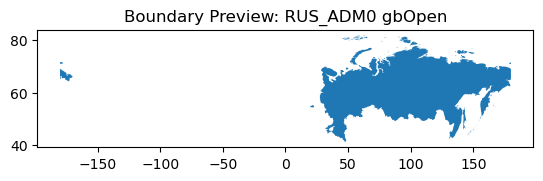

,id,Name,Level,ISO_Code,geometry
0,0,Russia,ADM0,RUS,"MULTIPOLYGON (((132.44899 42.8454, 132.44988 4..."


In [55]:
download_url = summaries[0]["boundary_download_urls"][0]
pr_title = summaries[0]["title"]

preview_boundary_from_url(download_url, title=pr_title)